In [1]:
import pandas as pd

# tweaking settings to see all columns on screen
pd.set_option('display.max_columns', None)

import numpy as np
import time
import math
from datetime import timedelta 
from datetime import datetime

N = 3 # number of lanes
FT_MI = 5280 # mile to feet conversion
TAO = 1.75 #
SPEED_CONVER = 5280/3600 # ft/s to mph conversion
L = 14.75 # typical length of a car
l = 5 # loop length
DEPARTURE_CONVER = 120 # hourly departure of v vehicles; raw data shows vehicles per 30 seconds

q_ramps = [1008,971,934,896,859,822,785,748,710,673,636,599,562,524,484]   # hypothetical q_ramp
q_ramps = [i* 2 for i in q_ramps]   # two ramps => double the discharge

## Data Cleaning

In [2]:
# read csv
df = pd.read_csv('78 EB.csv')

# select ['Name']s with word 'to'
df = df[df.Name.str.contains('to')] # those that dont have 'to' is radar data; no ramp data

# drop unnecessary columns
df = df[['Name', 'Time', 'Id', 'pcw1speed', 'pcw1vol', 'r_1_offcnt', 'r_2_offcnt', 'MlDetPostmile', 'pcw1occ']]

# rename columns
df.rename(columns={"pcw1speed": "V_ups",
                   "pcw1vol": "Q_ups",
                   "MlDetPostmile": "postmile",
                   "pcw1occ": "occupancy"}, inplace = True)

                   
# per_occ = density * (L+(lengthofloop=10))/(5280+density*l) # percent occupancy

# convert Nan values to 0
df['r_2_offcnt'] = df['r_2_offcnt'].fillna(0) # some have Nan values because there 

# change all V_ups value of 0 to the previous data
df['V_ups'] = df['V_ups'].replace(to_replace=0, method='ffill')

# convert datatype of 'time' to datetime 
def convtime(s):
    return datetime.strptime(s, '%H:%M:%S').time()

df['convtime'] = df['Time'].apply(convtime)

# Calculation

### Using arbitrary values of q_ramps

In [3]:
# calculate q_exit
df['q_exit'] = (df['r_1_offcnt'] + df['r_2_offcnt']) * DEPARTURE_CONVER
df.drop(['r_1_offcnt', 'r_2_offcnt'], axis=1, inplace = True)

# change all q_exit value of Nan to the previous data
df = df.fillna(method='ffill')

# change all Nan values to preceeding value
df = df.fillna(method='ffill')

In [4]:
# the larger the weight, the more efficient the n_ds
def weight(n_ds, Q_ups, V_ups):
    n_ups = Q_ups/V_ups
    n_goal = 1.15 * n_ups
    temp = n_ds-n_goal
    R = 10 # arbitrary variable for normal Gaussian distribution 
    return (1/((2*math.pi*R)**(1/2))) * math.e**((-1)*((n_ds-n_goal)**2)/(2*R))

In [5]:
Q_ups = df['Q_ups']
V_ups = df['V_ups']
q_exit = df['q_exit']

# calculate n_merge and V_merge
for q_ramp in q_ramps:
    n_merge = q_ramp/V_ups
    df['n_merge_' + str(q_ramp)] = n_merge
    df['V_merge_' + str(q_ramp)] = (FT_MI-n_merge*L) / (n_merge*TAO*SPEED_CONVER)
    
# split df by "Id" to shift values; we use some values that are recorded by sensors a minute ago and some current 
new_df = pd.DataFrame(columns = df.columns)
unique_ids = df['Id'].unique().tolist()    

for unique_id in unique_ids:
    temp_df = df.loc[df['Id'] == unique_id]
    
    # shift down values for calculation    
    temp_df['V_ups'] = temp_df['V_ups'].shift(1)
    temp_df['Q_ups'] = temp_df['Q_ups'].shift(1)
    temp_df.drop(temp_df.head(1).index,inplace=True)
    
    new_df = pd.concat([new_df, temp_df], axis=0, sort=True)
    
V_merge = new_df['V_merge_' + str(q_ramp)]
V_ups = new_df['V_ups']
Q_ups = new_df['Q_ups']
q_exit = new_df['q_exit']
    
# calculate n_ds
for q_ramp in q_ramps:
    new_df['n_ds_' + str(q_ramp)] = (1/V_ups) * (Q_ups + (q_ramp/N)) - ((1/N) * (q_exit/V_merge))

for q_ramp in q_ramps:
    R = 10 # arbitrary variable for normal Gaussian distribution 
    n_ds = new_df['n_ds_' + str(q_ramp)]
    new_df['weight_' + str(q_ramp)] = weight(n_ds, Q_ups, V_ups)

/Users/taekunkim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/taekunkim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/taekunkim/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

In [6]:
cols=[]

for q_ramp in q_ramps:
    cols.append('weight_' + str(q_ramp))

# choose the largest value across multiple columns
new_df = new_df.assign(q_ramp=new_df[cols].idxmax(axis=1))
new_df['q_ramp'] = new_df['q_ramp'].apply(lambda x: str(x).split('_')[1])
new_df = new_df[['Id', 'Name', 'Q_ups', 'Time', 'V_ups', 'convtime', 'occupancy', 'postmile', 'q_exit', 'q_ramp']]

### Using Gaussian Distribution

In [7]:
# mu: mean; best_rate
# sigma: standard deviation
def generate_range(mu, sigma=2):
    return np.random.normal(mu, sigma, 15).tolist()

In [8]:
matrix = pd.DataFrame(columns = new_df.columns)
best_q_ramps = new_df['q_ramp'].unique().tolist()

for best_q_ramp in best_q_ramps:
    temp_df = new_df.loc[new_df['q_ramp'] == best_q_ramp]
    q_ramps = generate_range(float(best_q_ramp))
    V_ups = temp_df['V_ups']
    Q_ups = temp_df['Q_ups']
    q_exit = temp_df['q_exit']
    
    for q_ramp in q_ramps:
        temp_df['n_merge_' + str(q_ramp)] = q_ramp/V_ups

    for q_ramp in q_ramps:
        n_merge = temp_df['n_merge_' + str(q_ramp)]
        temp_df['V_merge_' + str(q_ramp)] = (FT_MI-n_merge*L) / (n_merge*TAO*SPEED_CONVER)

    V_merge = temp_df['V_merge_' + str(q_ramp)]
    V_ups = temp_df['V_ups']
    Q_ups = temp_df['Q_ups']
    q_exit = temp_df['q_exit']
    
    for q_ramp in q_ramps:
        temp_df['n_ds_' + str(q_ramp)] = (1/V_ups) * (Q_ups + (q_ramp/N)) - ((1/N) * (q_exit/V_merge))
        
    for q_ramp in q_ramps:
        n_ds = temp_df['n_ds_' + str(q_ramp)]
        temp_df['weight_' + str(q_ramp)] = weight(n_ds, Q_ups, V_ups)
        
    cols=[]

    for q_ramp in q_ramps:
        cols.append('weight_' + str(q_ramp))

    # choose the largest value across multiple columns
    temp_df = temp_df.assign(q_ramp=temp_df[cols].idxmax(axis=1))
    temp_df['q_ramp'] = temp_df['q_ramp'].apply(lambda x: float(str(x).split('_')[1]))
    temp_df = temp_df[['Id', 'Name', 'Q_ups', 'Time', 'V_ups', 'convtime', 'occupancy', 'postmile', 'q_exit', 'q_ramp']]
    
    matrix = pd.concat([matrix, temp_df], axis=0, sort=True)

/Users/taekunkim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/taekunkim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/taekunkim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [14]:
V_ups = matrix['V_ups']
Q_ups = matrix['Q_ups']
q_exit = matrix['q_exit']
q_ramp = matrix['q_ramp']

matrix['n_merge'] = q_ramp/V_ups
n_merge = matrix['n_merge']

matrix['V_merge'] = (FT_MI-n_merge*L) / (n_merge*TAO*SPEED_CONVER)

V_merge = matrix['V_merge']

matrix['n_ds'] = (1/V_ups) * (Q_ups + (q_ramp/N)) - ((1/N) * (q_exit/V_merge))

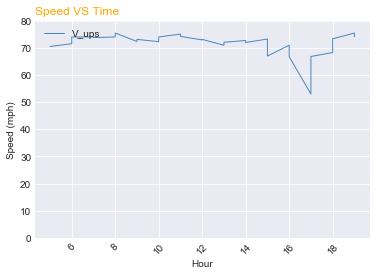

In [15]:
# libraries
import matplotlib.pyplot as plt

# Dataframe

toPlot = matrix.loc[matrix['Id'] == 201]
toPlot = toPlot[['V_ups', 'Time']]
toPlot['Time'] = pd.to_datetime(toPlot.Time)
toPlot = toPlot.groupby(pd.Grouper(key='Time', freq='30min')).mean().dropna()
  
# Change the style of plot
plt.style.use('seaborn-darkgrid')
 
# Create a color palette
palette = plt.get_cmap('Set1')
 
# Plot multiple lines
num=0
for column in toPlot.columns:
    num+=1
    plt.plot(toPlot.index.hour, toPlot[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)

# Add legend
plt.legend(loc=2, ncol=2)
 
# Add titles
plt.title("Speed VS Time", loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Hour")
plt.xticks(rotation = 45)
plt.ylabel("Speed (mph)")
plt.ylim(0, 80)

# Show the graph
plt.show()

In [16]:
matrix.head(1)

,Id,Name,Q_ups,Time,V_ups,convtime,occupancy,postmile,q_exit,q_ramp,n_merge,V_merge,n_ds
21,201,Jefferson St to 78 EB,213.0,05:31:00,73.0,05:31:00,1.1,0.858,120.0,965.370242,13.22425,149.811624,7.05889


In [ ]:
# time = "08:30:00"

# toPlot = matrix.loc[matrix['Time'] == time]
# toPlot = toPlot.drop(columns = ['Id', 'Time', 'convtime'])

# toPlot = toPlot.sort_values(by=['postmile'], ascending=False)
# toPlot['distance'] = toPlot[['postmile']].diff(periods=-1)
# df[-1, 'distance'] = 0.0

# toPlot['travel_time'] = toPlot['V_ups'] * toPlot['distance']

# # toPlot['volume'] = toPlot['V_ups'] * density
# toPlot